# Data Exploration for the Sepsis Dataset

In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np
from scipy.linalg import toeplitz
from copy import copy
import math
# import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns

# Geniuses that worked on hypertools did not update certain package and thus it produces warnings (they break jupyter lab)
import warnings
warnings.filterwarnings("ignore")

# Comment out if you don't want to see all of the values being printed (i.e. default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

current_dir = os.getcwd()
# utils_path = os.path.join(current_dir, '..', 'utils')
utils_path = os.path.join(current_dir, '../')
utils_abs_path = os.path.abspath(utils_path)
if utils_abs_path not in sys.path:
    sys.path.append(utils_abs_path)

import utils.get_data as get_data
# from impute_methods import *
from utils.impute_methods import *

DATA_PATH = get_data.get_dataset_abspath()

training_setA_path = DATA_PATH + 'training_setA'
training_setB_path = DATA_PATH + 'training_setB'

figures_path = "figures/"

In [2]:
num_files=100
df = get_data.get_dataset_as_df(files=num_files)
files, _ = get_data.get_dataset_as_np(files=num_files, concat_files=False)

data = df.values
column_names = df.columns.tolist()

Loading dataset...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 262.43it/s]


Done.
Loading dataset...


100%|██████████| 100/100 [00:00<00:00, 344.74it/s]

Done.


# Exploring NaN value counts

In [3]:
def sort_columns_by_data(column_names, data):

    # Sort the combined list based on the values
    sorted_ = sorted(list(zip(column_names, data)), key=lambda x: x[1])

    return [item[0] for item in sorted_], np.array([item[1] for item in sorted_])

In [4]:
def count_nan(arr):
    return np.sum(np.isnan(arr), axis=0)

# Count the number of NaN values in each column
nan_counts = count_nan(data)

In [8]:
print(f"Number of NaN values for each column of the dataset ({num_files} files)")

# Order the column names based on the number of NaN values in each
sorted_column_names, sorted_nan_counts = sort_columns_by_data(column_names, nan_counts)
sorted_nan_percentages = np.round(sorted_nan_counts/data.shape[0] * 100, 2)

# Print the NaN counts of each column
for index, (nan_count, column_name)  in enumerate(zip(sorted_nan_counts, sorted_column_names)):
    print(f"{column_name}: {nan_count}/{data.shape[0]} ({sorted_nan_percentages[index]}%)")

Number of NaN values for each column of the dataset (100 files)
Age: 0/3704 (0.0%)
Gender: 0/3704 (0.0%)
HospAdmTime: 0/3704 (0.0%)
ICULOS: 0/3704 (0.0%)
SepsisLabel: 0/3704 (0.0%)
HR: 302/3704 (8.15%)
Resp: 385/3704 (10.39%)
MAP: 389/3704 (10.5%)
O2Sat: 468/3704 (12.63%)
SBP: 646/3704 (17.44%)
Unit1: 1602/3704 (43.25%)
Unit2: 1602/3704 (43.25%)
DBP: 1985/3704 (53.59%)
Temp: 2475/3704 (66.82%)
FiO2: 3228/3704 (87.15%)
Glucose: 3261/3704 (88.04%)
Potassium: 3289/3704 (88.8%)
Hct: 3306/3704 (89.25%)
pH: 3307/3704 (89.28%)
BaseExcess: 3333/3704 (89.98%)
PaCO2: 3384/3704 (91.36%)
Hgb: 3387/3704 (91.44%)
BUN: 3392/3704 (91.58%)
Chloride: 3393/3704 (91.6%)
HCO3: 3397/3704 (91.71%)
WBC: 3425/3704 (92.47%)
Magnesium: 3426/3704 (92.49%)
Creatinine: 3441/3704 (92.9%)
Platelets: 3458/3704 (93.36%)
Phosphate: 3513/3704 (94.84%)
Calcium: 3519/3704 (95.01%)
PTT: 3536/3704 (95.46%)
SaO2: 3557/3704 (96.03%)
Lactate: 3569/3704 (96.36%)
AST: 3641/3704 (98.3%)
Alkalinephos: 3645/3704 (98.41%)
Bilirubin_t

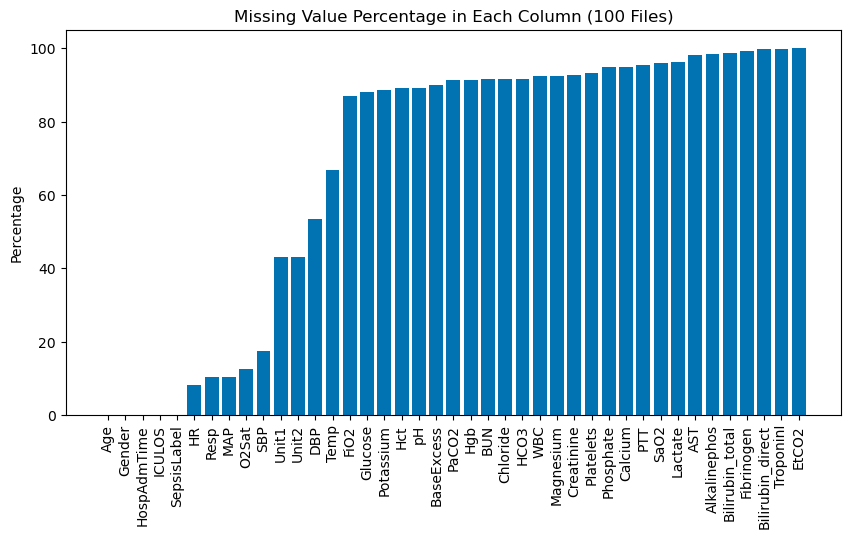

In [9]:
sns.set_palette("colorblind")

# Order the column names based on the number of NaN values in each
sorted_column_names, sorted_nan_counts = sort_columns_by_data(column_names, nan_counts)
sorted_nan_percentages = np.round(sorted_nan_counts/data.shape[0] * 100, 2)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"Missing Value Percentage in Each Column ({num_files} Files)")
ax.set_ylabel("Percentage")
ax.bar(sorted_column_names, sorted_nan_percentages)
ax.tick_params(axis='x', labelrotation=90)
plt.plot()
plt.savefig(figures_path + "NaN counts.png", bbox_inches = "tight");

# Data Imputation

Due to the high number of missing values in the dataset, it is necessary to perform *data imputation*. This involves estimating numerical values that can replace the missing values while maintaining the distriubition of each feature as well as the colinearities between features.

## Methods of Imputation

### 1. Mean/Median/Mode Imputation
- **Description**: NaN values are replaced with the mean, median, or mode of the available data for the feature.
- **Use Cases**: Applicable for numerical and categorical data.
- **Pros**: Simple, easy to implement.
- **Cons**: May distort the original distribution if missingness is not at random.

### 2. Regression Imputation
- **Description**: Predictive models (e.g., linear regression) are used to estimate missing values based on other variables in the dataset.
- **Use Cases**: Suitable for cases where variables are correlated.
- **Pros**: Captures relationships between variables.
- **Cons**: Assumes linearity and may be sensitive to outliers.

### 3. K-Nearest Neighbors (KNN) Imputation
- **Description**: Missing values are imputed based on the values of their nearest neighbors in the feature space.
- **Use Cases**: Effective for datasets with continuous features and well-defined distance metrics.
- **Pros**: Preserves relationships in the data.
- **Cons**: Computationally intensive for large datasets.

### 4. Multiple Imputation
- **Description**: Generates multiple plausible values for each missing data point, allowing for uncertainty estimation.
- **Use Cases**: Useful when the assumption of missing completely at random (MCAR) is violated.
- **Pros**: Accounts for variability and uncertainty.
- **Cons**: Complexity increases with the number of imputations.

### 5. Random Forest Imputation
- **Description**: Utilizes a random forest algorithm to predict missing values based on other variables in the dataset.
- **Use Cases**: Suitable for datasets with complex relationships and mixed data types.
- **Pros**: Handles non-linearity and interactions well.
- **Cons**: May overfit if not properly tuned.

### 6. Expectation-Maximization (EM) Imputation
- **Description**: Iterative algorithm that estimates missing values by maximizing the likelihood of observed data.
- **Use Cases**: Effective for multivariate normal distributions and when missingness mechanisms are not known.
- **Pros**: Flexible and can handle various types of missing data.
- **Cons**: Convergence issues with high-dimensional data.


In [10]:
# Let us look at a random specific patient file

# Change to empty strign to get random file
specific_filename = "p001146.psv"

# From training set A
file_path = random.choice(os.listdir(training_setA_path)) if specific_filename == "" else specific_filename
file_data = pd.read_csv(training_setA_path + "/" + file_path, sep='|')
print(file_path)
print(file_data['HR'])

p001146.psv
0     88.0
1     76.0
2     72.0
3     81.0
4      NaN
5     94.0
6     80.0
7     88.0
8     78.0
9     80.0
10    86.0
11    86.0
12     NaN
13     NaN
14    75.0
15    69.0
16     NaN
17    85.0
18    83.0
19    84.0
20    73.0
21    73.0
22     NaN
23    97.0
Name: HR, dtype: float64


In [11]:
# This linearly interpolates the Heart Rate values which could be sufficient
imputed_data = impute_linear_interpolation(file_data, 'HR')

print(imputed_data['HR'])

0     88.000000
1     76.000000
2     72.000000
3     81.000000
4     87.500000
5     94.000000
6     80.000000
7     88.000000
8     78.000000
9     80.000000
10    86.000000
11    86.000000
12    82.333333
13    78.666667
14    75.000000
15    69.000000
16    77.000000
17    85.000000
18    83.000000
19    84.000000
20    73.000000
21    73.000000
22    85.000000
23    97.000000
Name: HR, dtype: float64


In [3]:
df["Resp"]

0        NaN
1       19.0
2       22.0
3       30.0
4       24.5
        ... 
3699    16.0
3700    17.0
3701    18.0
3702    14.0
3703    18.0
Name: Resp, Length: 3704, dtype: float64

In [4]:
imputed_data = impute_forward_fill_last_recorded(df, "Resp")
imputed_data["Resp"]

0       19.158406
1       19.000000
2       22.000000
3       30.000000
4       24.500000
          ...    
3699    16.000000
3700    17.000000
3701    18.000000
3702    14.000000
3703    18.000000
Name: Resp, Length: 3704, dtype: float64

## Data Exploration

### Data imbalance

In [57]:
# Obtain the ratio SepsisLabel=0:SepsisLabel=1

label_counts = df["SepsisLabel"].value_counts()
zero_count = label_counts[0.0] 
one_count = label_counts[1.0]

divisor = math.gcd(zero_count, one_count)

ratio = f"{int(zero_count/divisor)}:{int(one_count/divisor)}"

print(f"Ratio SepsisLabel=0:SepsisLabel=1 is {ratio}")

Ratio SepsisLabel=0:SepsisLabel=1 is 3569:135
